In [1]:
import sys
import os

srcpath = os.path.abspath("../src")
if srcpath not in sys.path:
    sys.path.append(srcpath)

import torch

import pandas as pd

from mhcenc import MHCEncoder
from dataset import Dataset
from bigmhc import BigMHC
from mhcuid import mhcuid

datadir  = "../data"
traindir = os.path.join(datadir, "el_train")

print("making MHCEncoder...", end="")
mhcenc = MHCEncoder.read(os.path.join(datadir, "pseudoseqs.csv"))
print("done")

print("reading data...", end="")
eltrain = pd.read_csv(os.path.join(datadir, "el_train.csv"))
eltest  = pd.read_csv(os.path.join(datadir, "el.csv"))
print("done")

print("loading model...", end="")
model = BigMHC.load("../models/bigmhc_el").to(0)
print("done")

making MHCEncoder...done
reading data...done
loading model...done


In [2]:
# The only available HLA-A/B/C AlphaFold entries as of May 4, 2022:
# HLA-A*74:01 https://alphafold.com/entry/P04439
# HLA-B*67:01 https://alphafold.com/entry/P01889
# HLA-C*15:02 https://alphafold.com/entry/P10321

hlaA = "HLAA7401"
hlaB = "HLAB6701"
hlaC = "HLAC1502"

# We do not have any HLA-B*67:01 training or testing data,
# so we find the nearest (L1) MHC encoding that exists in training data
minmhc = None
mindif = 30
for mhc in [mhc for mhc in eltrain["mhc"].unique() if mhc.startswith("HLA-B")]:
    dif = int(torch.norm((mhcenc[hlaB] - mhcenc[mhc]).float(), p=1) / 2)
    if dif <= mindif:
        mindif = dif
        minmhc = mhc
print("Substituting {} with {} which differs by {} encoded positions".format(
    hlaB, minmhc, mindif))
hlaB = mhcuid(minmhc)

Substituting HLAB6701 with HLA-B*42:01 which differs by 3 encoded positions


In [3]:
def getMHCMeanAttention(df):
    tmpfp = "cache/tmp.csv"
    df.iloc[:,1].to_csv(tmpfp, index=False, header=False)
    pmhcs = Dataset.readPMHCs(
        fp=tmpfp,
        allele=df.iloc[0,0],
        pepcol=0,
        verbose=False)
    dataset = Dataset(pmhcs=pmhcs, mhcenc=mhcenc)
    dataset.makebats(maxbat=6144)
    loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=None,
        shuffle=False,
        num_workers=4,
        prefetch_factor=16)
    attention = None
    with torch.no_grad():
        for idx,bat in enumerate(loader):
            _, att = model(
                mhc=bat.mhc.to(0),
                pep=bat.pep.to(0))
            att = torch.sum(att,dim=0).cpu()
            if attention is None:
                attention = att
            else:
                attention += att
    return (attention / len(df)).tolist()


def getMeanAttention(df, cache):
    if os.path.isfile(cache):
        print("reading cache file {}...".format(cache), end="")
        attention = pd.read_pickle(cache)
        print("done")
    else:
        if not os.path.exists(os.path.dirname(cache)):
            os.makedirs(os.path.dirname(cache))
        print("processing {} pMHC instances...".format(len(df)))
        alleles = sorted(df.iloc[:,0].unique())
        attention = list()
        for idx,mhc in enumerate(alleles):
            print("  {}/{} {}...".format(idx+1,len(alleles),mhc), end="")
            mhcdf = df[df.iloc[:,0]==mhc]
            attention.append([mhc,0,getMHCMeanAttention(mhcdf[mhcdf.iloc[:,2]==0])])
            attention.append([mhc,1,getMHCMeanAttention(mhcdf[mhcdf.iloc[:,2]==1])])
            print("done")
        attention = pd.DataFrame(
            columns=["mhc","tgt","att"],
            data=attention)
        attention.to_pickle(cache)
    return attention


cacheMeanTrain = "cache/el_mean_att_train.pkl"
cacheMeanTest  = "cache/el_mean_att_test.pkl"

trainMeanAttention = getMeanAttention(eltrain, cacheMeanTrain)
testMeanAttention  = getMeanAttention(eltest,  cacheMeanTest)

processing 17058504 pMHC instances...
  1/150 HLA-A*01:01...done
  2/150 HLA-A*01:03...done
  3/150 HLA-A*02:01...done
  4/150 HLA-A*02:02...done
  5/150 HLA-A*02:03...done
  6/150 HLA-A*02:04...done
  7/150 HLA-A*02:05...done
  8/150 HLA-A*02:06...done
  9/150 HLA-A*02:07...done
  10/150 HLA-A*02:11...done
  11/150 HLA-A*02:14...done
  12/150 HLA-A*03:01...done
  13/150 HLA-A*03:02...done
  14/150 HLA-A*11:01...done
  15/150 HLA-A*11:02...done
  16/150 HLA-A*23:01...done
  17/150 HLA-A*24:02...done
  18/150 HLA-A*24:06...done
  19/150 HLA-A*24:07...done
  20/150 HLA-A*24:13...done
  21/150 HLA-A*25:01...done
  22/150 HLA-A*26:01...done
  23/150 HLA-A*26:02...done
  24/150 HLA-A*26:03...done
  25/150 HLA-A*29:02...done
  26/150 HLA-A*30:01...done
  27/150 HLA-A*30:02...done
  28/150 HLA-A*30:03...done
  29/150 HLA-A*30:04...done
  30/150 HLA-A*31:01...done
  31/150 HLA-A*32:01...done
  32/150 HLA-A*33:01...done
  33/150 HLA-A*33:03...done
  34/150 HLA-A*34:01...done
  35/150 HLA-A*34:0

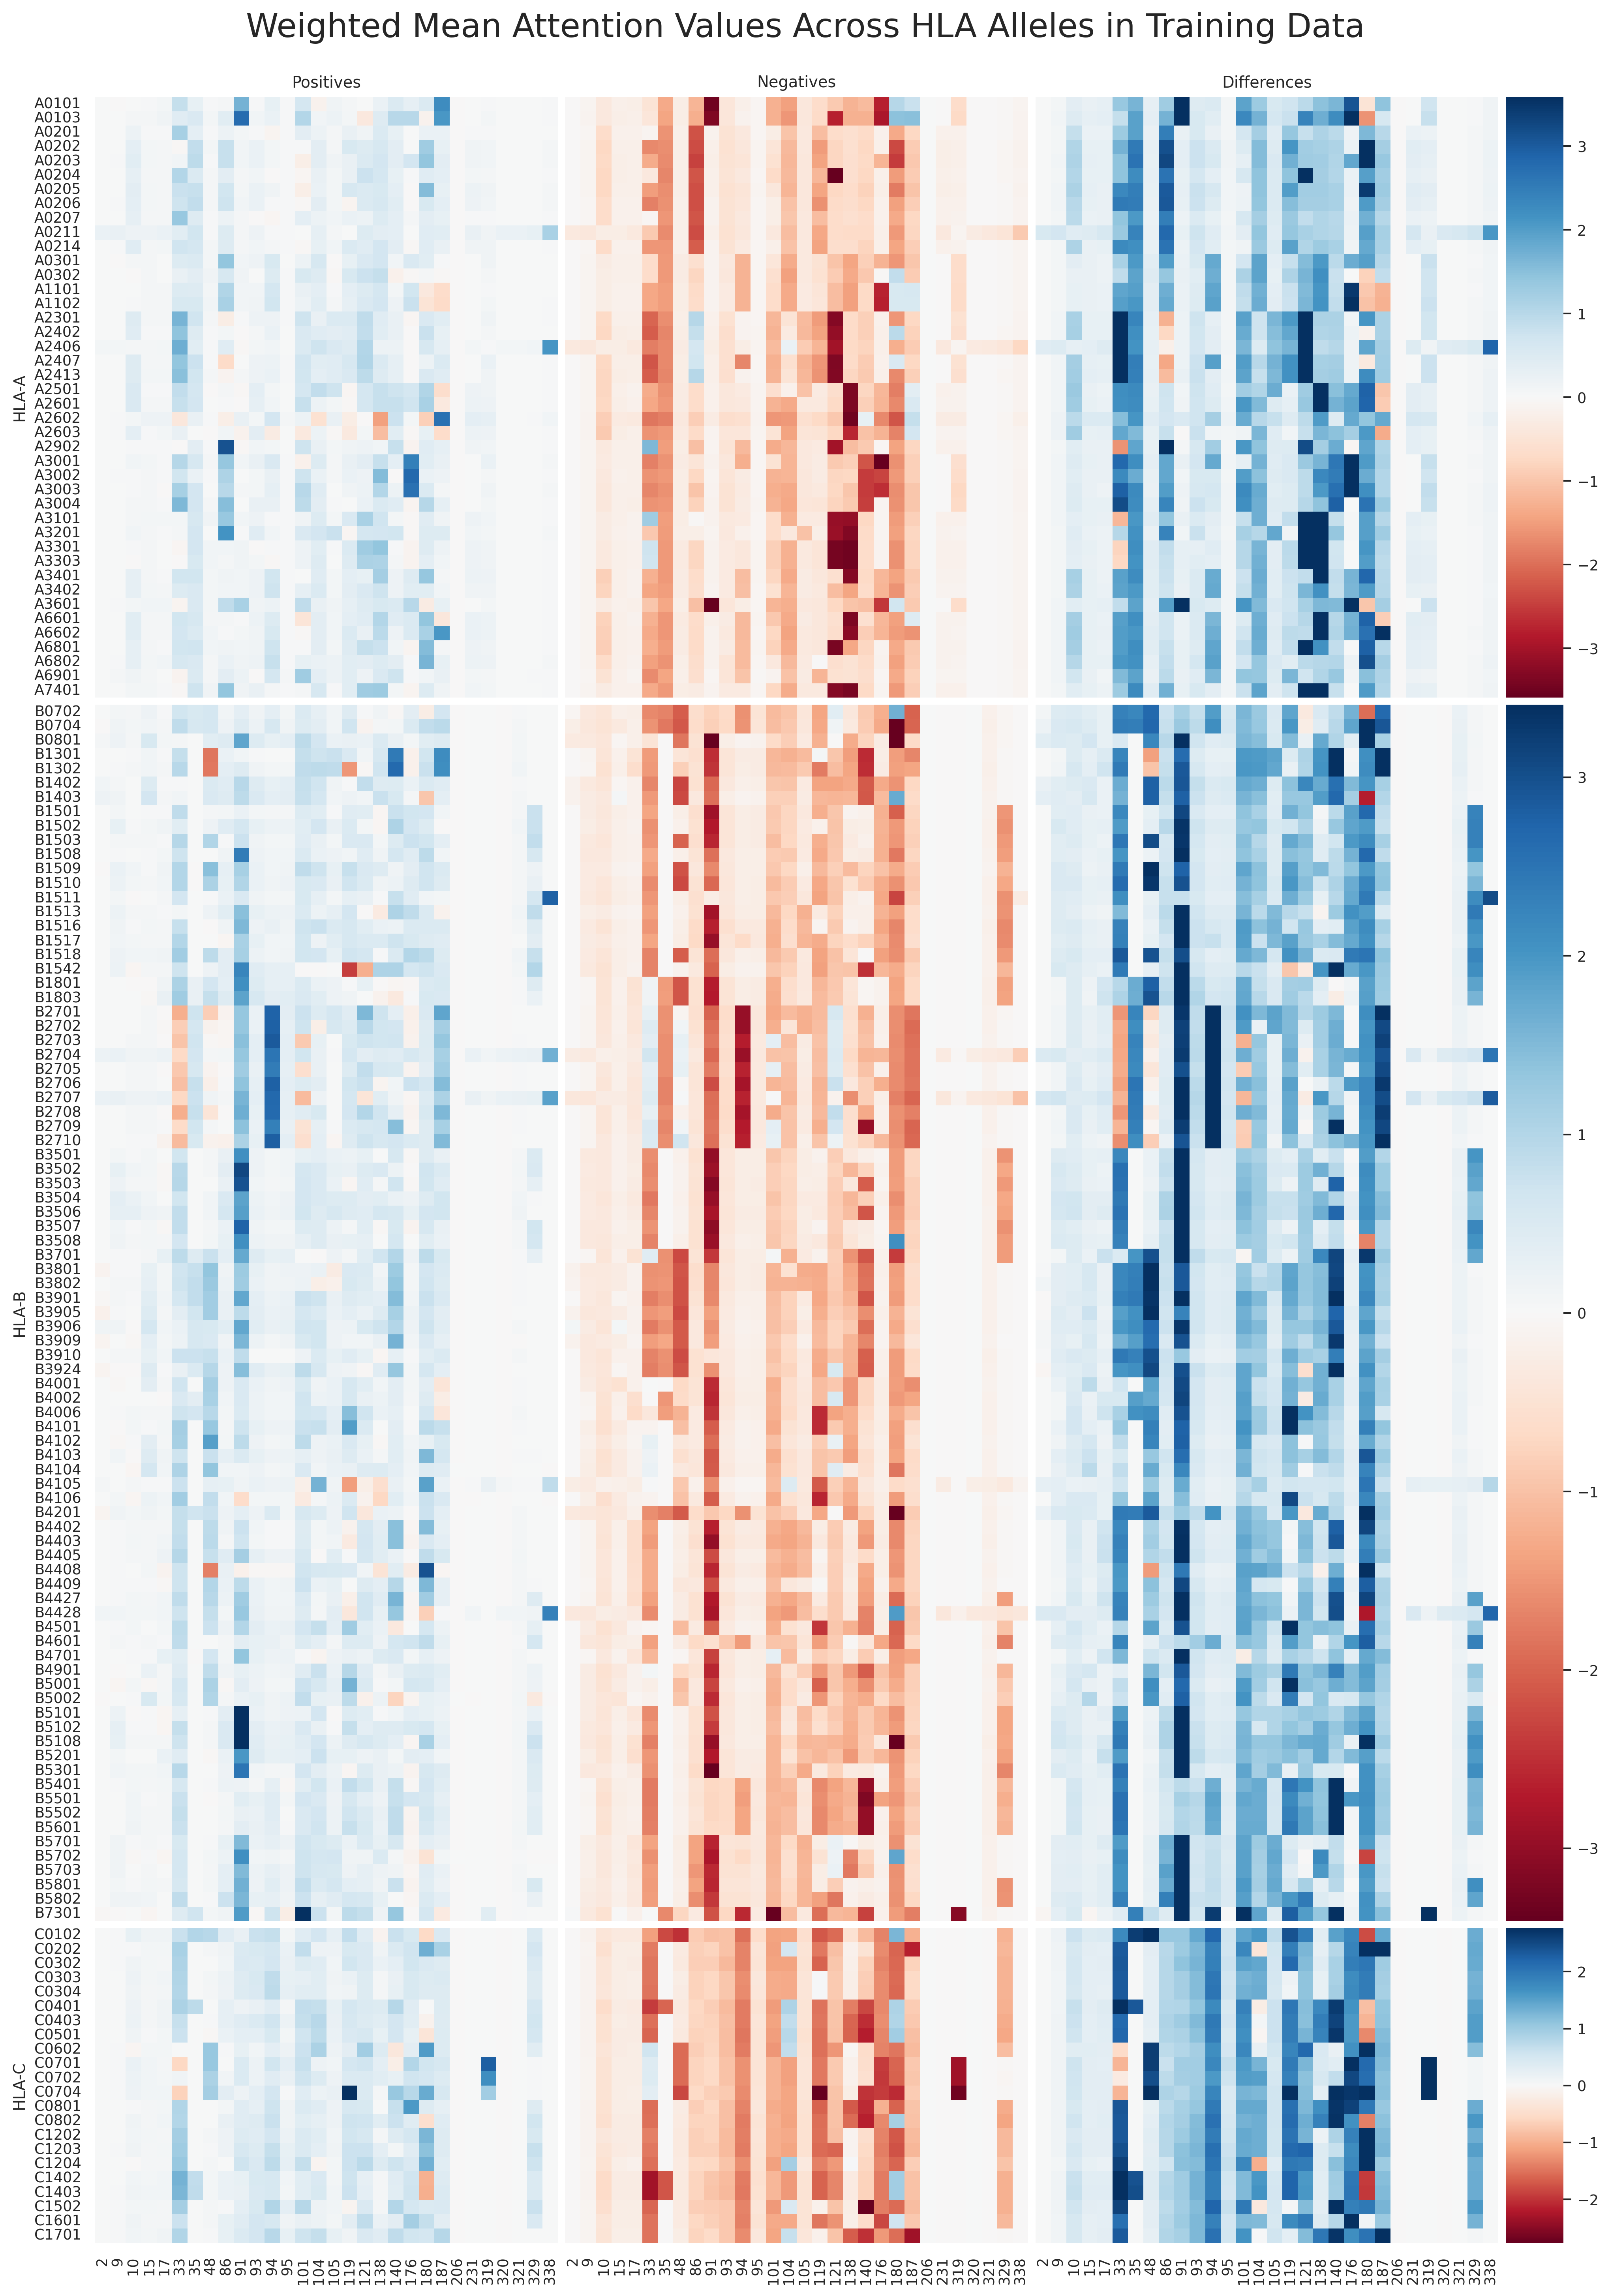

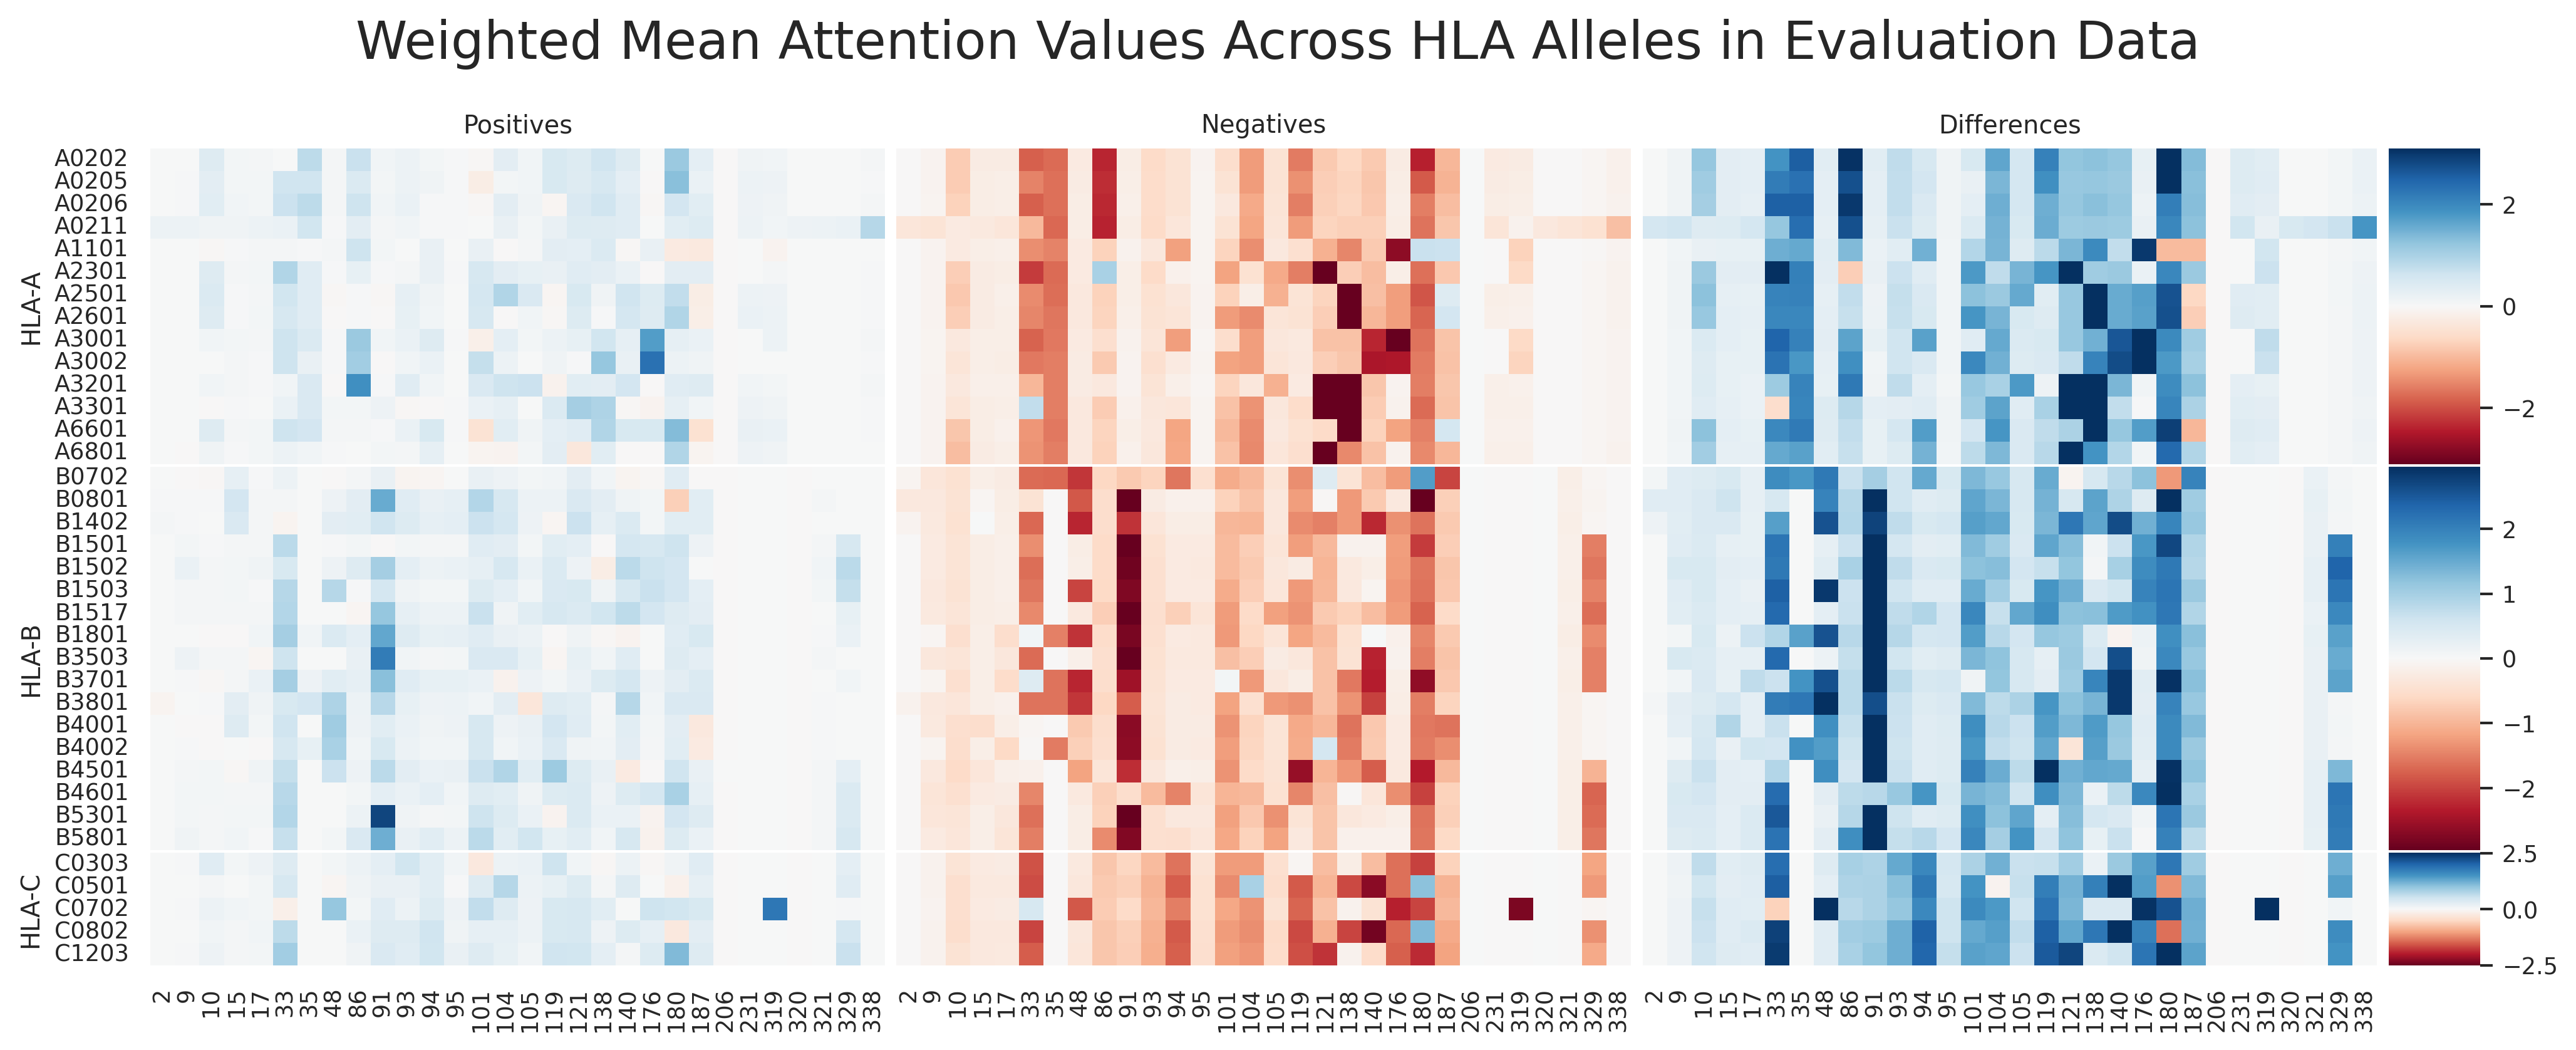

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns


def makeAttentionHeatmaps(df, attention, title):
    
    df.iloc[:,0] = df.iloc[:,0].apply(mhcuid)
    attention["mhc"] = attention["mhc"].apply(mhcuid)
    
    neg = {'A':[], 'B':[], 'C':[]}
    pos = {'A':[], 'B':[], 'C':[]}
    dif = {'A':[], 'B':[], 'C':[]}
    
    alldiff = dict()
    
    yticklabels = {'A':[], 'B':[], 'C':[]}
    
    alleles = sorted(df.iloc[:,0].unique())

    for mhc in alleles:
        if not mhc.startswith("HLA"):
            continue
        rows = attention[attention["mhc"]==mhc]
        N = torch.tensor(rows[rows["tgt"]==0]["att"].iloc[0])
        P = torch.tensor(rows[rows["tgt"]==1]["att"].iloc[0])
        D = P-N
        alldiff[mhc] = D.tolist()

        neg[mhc[3]].append(N.tolist())
        pos[mhc[3]].append(P.tolist())
        dif[mhc[3]].append(D.tolist())

        yticklabels[mhc[3]].append(mhc[3:])

    neg = {k:torch.tensor(v) for k,v in neg.items()}
    pos = {k:torch.tensor(v) for k,v in pos.items()}
    dif = {k:torch.tensor(v) for k,v in dif.items()}

    absmax = {
        x:torch.concat((neg[x],pos[x],dif[x]), dim=1).flatten().quantile(0.99)
        for x in list("ABC")}

    xticklabels = list()
    for x in [x.split('_')[0] for x in mhcenc.cols]:
        if len(xticklabels) and xticklabels[-1]==x:
            continue
        xticklabels.append(x)


    sns.set_context("paper")
    style="whitegrid"
    rc={"axes.facecolor": "0.99",
        "grid.color": "0.95",
        "axes.edgecolor": "0.90"}

    nA = len(yticklabels['A'])
    nB = len(yticklabels['B'])
    nC = len(yticklabels['C'])


    with sns.axes_style(style=style, rc=rc):

        heatmaps = plt.figure(figsize=(16,24*len(alleles)/150), dpi=300)
        gs = heatmaps.add_gridspec(
            nrows=3,
            ncols=4,
            wspace=0.02,
            hspace=0.01,
            width_ratios=[0.32,0.32,0.32,0.04],
            height_ratios=[
                nA / (nA+nB+nC),
                nB / (nA+nB+nC),
                nC / (nA+nB+nC)])
        ax = gs.subplots()

        mapdata = [pos, neg, dif]

        for y,sup in enumerate(list("ABC")):
            for x,data in enumerate(mapdata):

                sns.heatmap(
                    data=data[sup],
                    ax=ax[y][x],
                    cmap="RdBu",
                    xticklabels=xticklabels,
                    yticklabels=yticklabels[sup] if not x else [],
                    vmin=-absmax[sup],
                    vmax=absmax[sup],
                    cbar_ax=ax[y][3])

                if y==0:
                    if x==0:
                        ax[y][x].set_title("Positives")
                    elif x==1:
                        ax[y][x].set_title("Negatives")
                    else:
                        ax[y][x].set_title("Differences")
                if x==0:
                    ax[y][x].set_ylabel("HLA-{}".format(sup))
                
        heatmaps.suptitle(title, fontsize=20, y=0.91 if len(alleles)==150 else 1)
    
    return heatmaps, alldiff


savedir = "figs"

if not os.path.exists(savedir):
    os.makedirs(savedir)

trainmaps, trainmapsdif = makeAttentionHeatmaps(
    df=eltrain,
    attention=trainMeanAttention,
    title="Weighted Mean Attention Values Across HLA Alleles in Training Data")

trainmaps.savefig(os.path.join(savedir,"train_att_map.png" ), bbox_inches="tight")

testmaps, testmapsdif = makeAttentionHeatmaps(
    df=eltest,
    attention=testMeanAttention,
    title="Weighted Mean Attention Values Across HLA Alleles in Evaluation Data")

testmaps.savefig(os.path.join(savedir,"test_att_map.png" ), bbox_inches="tight")

In [5]:
import py3Dmol
import matplotlib

import numpy as np


def plot3d(pdb, mapsdiff, mhc, q, absmax):
    
    mhc = mhcuid(mhc)
    
    att = getResAtt(mapsdiff, mhc)
    
    att = [(x+absmax) / (2*absmax) for x in att]
    
    with open(pdb) as f:
        system = "".join([x for x in f])
    
    view = py3Dmol.view(width=600, height=600)
    view.addModelsAsFrames(system)
    
    cmap = matplotlib.cm.get_cmap("cool_r")
    cmap = [(cmap(att[x]) if att[x] > -1 else (0.9,0.9,0.9)) for x in range(len(att))]
    cmap = ["#{:02X}{:02X}{:02X}".format(
        int(c[0]*255),
        int(c[1]*255),
        int(c[2]*255)) for c in cmap]
    
    for res in range(len(att)):
        style = {"cartoon": {"color":cmap[res], "arrows":"True"}}
        # if att[res] >= 0:
        #     style["stick"] = {}
        view.setStyle({"resi":res+1}, style)
    
    view.zoomTo()
    
    alpha = 2*np.arccos(q[3])
    sin = np.sin(alpha) / 2
    x = q[0] / sin
    y = q[1] / sin
    z = q[2] / sin
    norm = np.linalg.norm([x,y,z])
    x /= norm
    y /= norm
    z /= norm
    view.rotate(np.degrees(alpha), {'x':x,'y':y,'z':z})
    
    view.show()
    
    view.clim(-4,4)

def getResAtt(att, mhc):
    att = att[mhc]
    res = (-1e9) * torch.ones(len(mhcenc[mhc]))
    attidx = 0
    for x in range(len(res)):
        if mhcenc[mhc][x]:
            col = int(mhcenc.cols[x].split('_')[0])
            res[col] = att[attidx]
            attidx += 1
    return res.tolist()


# to get the viewer quaternion, first execute the following in the web console:
# 
# >>  viewer = ""
#     for (var name in this)
#       if (name.startsWith("viewer_"))
#         viewer = name
#     console.log(viewer)
# 
# 
# which will print the name of the most recent viewer, like this:
#     viewer_16548849854127703
# 
# then, execute:
# >>  viewer_16548849854127703.getView()
# 
# which will return an array of 8 elements, of which the last four can be
# copy/pasted as an argument to getResAtt as seen below.
# 
# this can be used to manually rotate the view and then hardcode the
# quaternion to have replicatable viewing angles.

hlaAatt = trainmapsdif[hlaA]
hlaBatt = trainmapsdif[hlaB]
hlaCatt = trainmapsdif[hlaC]

minatt = min([*hlaAatt, *hlaBatt, *hlaCatt])
maxatt = max([*hlaAatt, *hlaBatt, *hlaCatt])

absmax = max(abs(minatt), abs(maxatt))

plot3d("pdb/hlaa7401.pdb", trainmapsdif, hlaA,
       [0.6180359409390861, 0.7459885120701037, 0.2326389501405009, 0.08609201150221249],
        absmax)
plot3d("pdb/hlab6701.pdb", trainmapsdif, hlaB,
       [-0.38265398084125163, 0.23174604311868532, 0.043516241833652554, 0.8932950459628953],
        absmax)
plot3d("pdb/hlac1502.pdb", trainmapsdif, hlaC,
       [0.3111048658258353, 0.9467606286276827, -0.021276470427862834, -0.08003365758314601],
        absmax)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

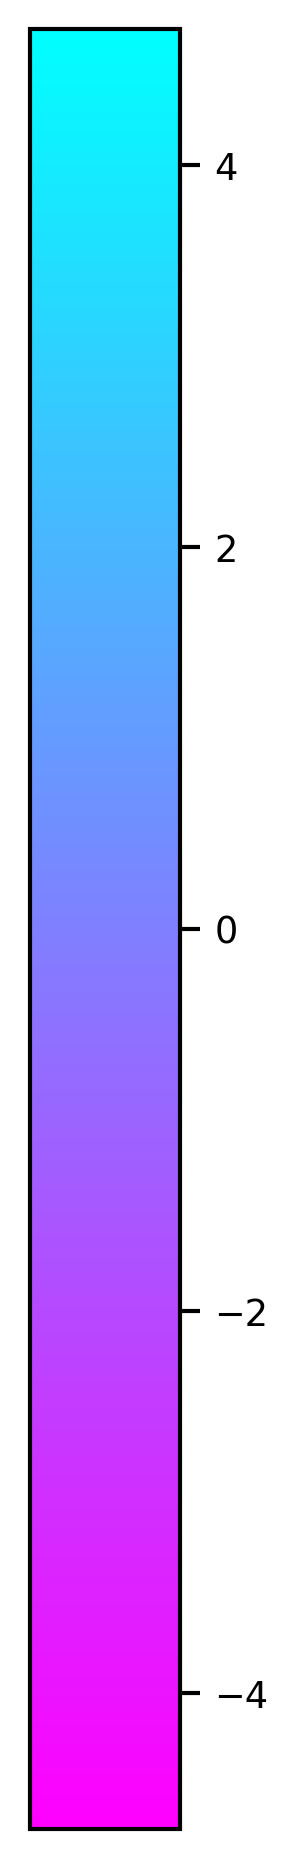

In [6]:
import pylab as pl

    
# Adapted from https://stackoverflow.com/a/16599889

pl.figure(figsize=(1, 12), dpi=300)
pl.imshow(np.array([[-absmax,absmax]]), cmap="cool_r")
pl.gca().set_visible(False)
cax = pl.axes([0.1, 0.1, 0.5, 0.5])
pl.colorbar(orientation="vertical", cax=cax)
pl.savefig(os.path.join(savedir, "colorbar.png"), facecolor="white")